In [46]:
library(Signac)
library(Seurat)
library(motifmatchr)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Pando)
library(dplyr)
library(EnsDb.Hsapiens.v86)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
data(motifs) # load motifs from pando

In [47]:
# load our datasobj <- readRDS('{PATH_1}')

In [48]:
sobj

An object of class Seurat 
345701 features across 7994 samples within 5 assays 
Active assay: chromvar (746 features, 0 variable features)
 4 other assays present: SCT, ATAC, RNA, PRTB
 5 dimensional reductions calculated: integrated_lsi, atac.umap, pca, rna.umap, wnn.umap

In [49]:
# load dasa hic2 vs dasa nt dea resultsdiff_genes <- read.csv('{PATH_2}')

In [50]:
# fix colname
diff_genes <- diff_genes %>% rename(gene=X)

In [51]:
head(diff_genes)

,gene,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,HBA1,6.179477e-114,1.373516,0.978,0.784,1.377344e-109
2,MGST3,2.636843e-99,1.167715,0.815,0.409,5.877259e-95
3,PRDX2,2.151090e-104,1.129496,0.970,0.769,4.794565e-100
4,AMMECR1,7.473797e-91,1.119685,0.778,0.387,1.665835e-86
5,CTSE,0.000000e+00,1.082244,0.546,0.005,0.000000e+00
6,HBG2,3.846958e-137,1.034128,1.000,1.000,8.574484e-133


In [52]:
DefaultAssay(sobj) <- "ATAC"

In [53]:
# update annotations to newest
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)

# change to UCSC style since the data was mapped to hg19
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "hg38"

# add the gene information to the object
Annotation(sobj) <- annotations

Annotation(sobj)

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

GRanges object with 3021151 ranges and 5 metadata columns:
                  seqnames        ranges strand |           tx_id   gene_name
                     <Rle>     <IRanges>  <Rle> |     <character> <character>
  ENSE00001489430     chrX 276322-276394      + | ENST00000399012      PLCXD1
  ENSE00001536003     chrX 276324-276394      + | ENST00000484611      PLCXD1
  ENSE00002160563     chrX 276353-276394      + | ENST00000430923      PLCXD1
  ENSE00001750899     chrX 281055-281121      + | ENST00000445062      PLCXD1
  ENSE00001489388     chrX 281192-281684      + | ENST00000381657      PLCXD1
              ...      ...           ...    ... .             ...         ...
  ENST00000361739    chrMT     7586-8269      + | ENST00000361739      MT-CO2
  ENST00000361789    chrMT   14747-15887      + | ENST00000361789      MT-CYB
  ENST00000361851    chrMT     8366-8572      + | ENST00000361851     MT-ATP8
  ENST00000361899    chrMT     8527-9207      + | ENST00000361899     MT-ATP6
  ENS

In [54]:
# make lists of up and down reg'd genes
up_genes <- diff_genes[diff_genes$avg_log2FC > 0, 1]
down_genes <- diff_genes[diff_genes$avg_log2FC < 0, 1]

In [55]:
# txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene
# ensdb <- EnsDb.Hsapiens.v86
# seqlevelsStyle(ensdb) <- "UCSC"
# get gene ranges for these genes
up_granges <- subset(annotations, gene_name %in% up_genes)
down_granges <- subset(annotations, gene_name %in% down_genes)

In [56]:
up_granges

GRanges object with 22002 ranges and 5 metadata columns:
                  seqnames            ranges strand |           tx_id
                     <Rle>         <IRanges>  <Rle> |     <character>
  ENSE00001045638     chrX 48786554-48786645      + | ENST00000376670
  ENSE00001471287     chrX 48786573-48786645      + | ENST00000376665
  ENSE00001471304     chrX 48791091-48791329      + | ENST00000376665
  ENSE00001471304     chrX 48791091-48791329      + | ENST00000376670
  ENSE00000670938     chrX 48791844-48792221      + | ENST00000376665
              ...      ...               ...    ... .             ...
  ENST00000635620    chr15 65737707-65737945      - | ENST00000635620
  ENST00000635620    chr15 65738706-65738875      - | ENST00000635620
  ENST00000635620    chr15 65741715-65741784      - | ENST00000635620
  ENST00000635620    chr15 65752379-65752628      - | ENST00000635620
  ENST00000635620    chr15 65756140-65756450      - | ENST00000635620
                    gene_name    

In [57]:
# buffer our genes
up_granges <- up_granges + 5000
down_granges <- down_granges + 5000

In [58]:
# Get the peak ranges from your Seurat object
peak_ranges <- granges(sobj)

# Find peaks that overlap with genes of interest
up_overlapping_peaks <- findOverlaps(peak_ranges, up_granges)
down_overlapping_peaks <- findOverlaps(peak_ranges, down_granges)

# Get the names of the overlapping peaks
up_overlapping_peak_names <- subjectHits(up_overlapping_peaks)
down_overlapping_peak_names <- subjectHits(down_overlapping_peaks)

# Subset your Seurat object based on these peaks
up_sobj <- sobj[up_overlapping_peak_names, ]
down_sobj <- sobj[down_overlapping_peak_names, ]

Warning message in rownames(x = object) == rownames(x = new.data):
"longer object length is not a multiple of shorter object length"
Warning message in SetAssayData.ChromatinAssay(object = new.assay, slot = "motifs", :
"Features do not match in ChromatinAssay and Motif object.
                Subsetting the Motif object."
Warning message in rownames(x = object) == rownames(x = new.data):
"longer object length is not a multiple of shorter object length"
Warning message in SetAssayData.ChromatinAssay(object = new.assay, slot = "motifs", :
"Features do not match in ChromatinAssay and Motif object.
                Subsetting the Motif object."


In [59]:
# subset for cells of interest
up_sobj <- subset(up_sobj, idents = c("DASA_HIC2", "DASA_NT"))
up_sobj

An object of class Seurat 
19075 features across 2990 samples within 1 assay 
Active assay: ATAC (19075 features, 0 variable features)
 4 dimensional reductions calculated: integrated_lsi, atac.umap, rna.umap, wnn.umap

In [60]:
down_sobj <- subset(down_sobj, idents = c("DASA_HIC2", "DASA_NT"))
down_sobj

An object of class Seurat 
34172 features across 2990 samples within 1 assay 
Active assay: ATAC (34172 features, 0 variable features)
 4 dimensional reductions calculated: integrated_lsi, atac.umap, rna.umap, wnn.umap

In [61]:
# add motif information
up_sobj <- AddMotifs(up_sobj, genome = BSgenome.Hsapiens.UCSC.hg38, pfm = motifs)
down_sobj <- AddMotifs(down_sobj, genome = BSgenome.Hsapiens.UCSC.hg38, pfm = motifs)

Building motif matrix



Finding motif positions

Creating Motif object

Warning message in CreateMotifObject(data = motif.matrix, positions = motif.positions, :
"Non-unique motif names supplied, making unique"
Warning message in SetAssayData.ChromatinAssay(object = object, slot = "motifs", :
"Features do not match in ChromatinAssay and Motif object.
                Subsetting the Motif object."
Building motif matrix

Finding motif positions

Creating Motif object

Warning message in CreateMotifObject(data = motif.matrix, positions = motif.positions, :
"Non-unique motif names supplied, making unique"
Warning message in SetAssayData.ChromatinAssay(object = object, slot = "motifs", :
"Features do not match in ChromatinAssay and Motif object.
                Subsetting the Motif object."


In [63]:
# gather the footprinting information for sets of motifs
up_sobj <- Footprint(
  object = up_sobj,
  motif.name = c("HIC2", "TCF4"),
  genome = BSgenome.Hsapiens.UCSC.hg38
)
# gather the footprinting information for sets of motifs
down_sobj <- Footprint(
  object = down_sobj,
  motif.name = c("HIC2", "TCF4"),
  genome = BSgenome.Hsapiens.UCSC.hg38
)

Computing Tn5 insertion bias

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Extracting reads in requested region

Computing observed Tn5 insertions per base

Computing base composition at motif sites

Computing expected Tn5 insertions per base

Finding + strand cut sites

Finding - strand cut sites

Computing observed Tn5 insertions per base

Computing base composition at motif sites

Computing expected Tn5 insertions per base

Finding + strand cut sites

Finding - strand

Warning message:
"Removed 1018 rows containing missing values (`geom_label_repel()`)."
Warning message:
"Removed 1026 rows containing missing values (`geom_label_repel()`)."


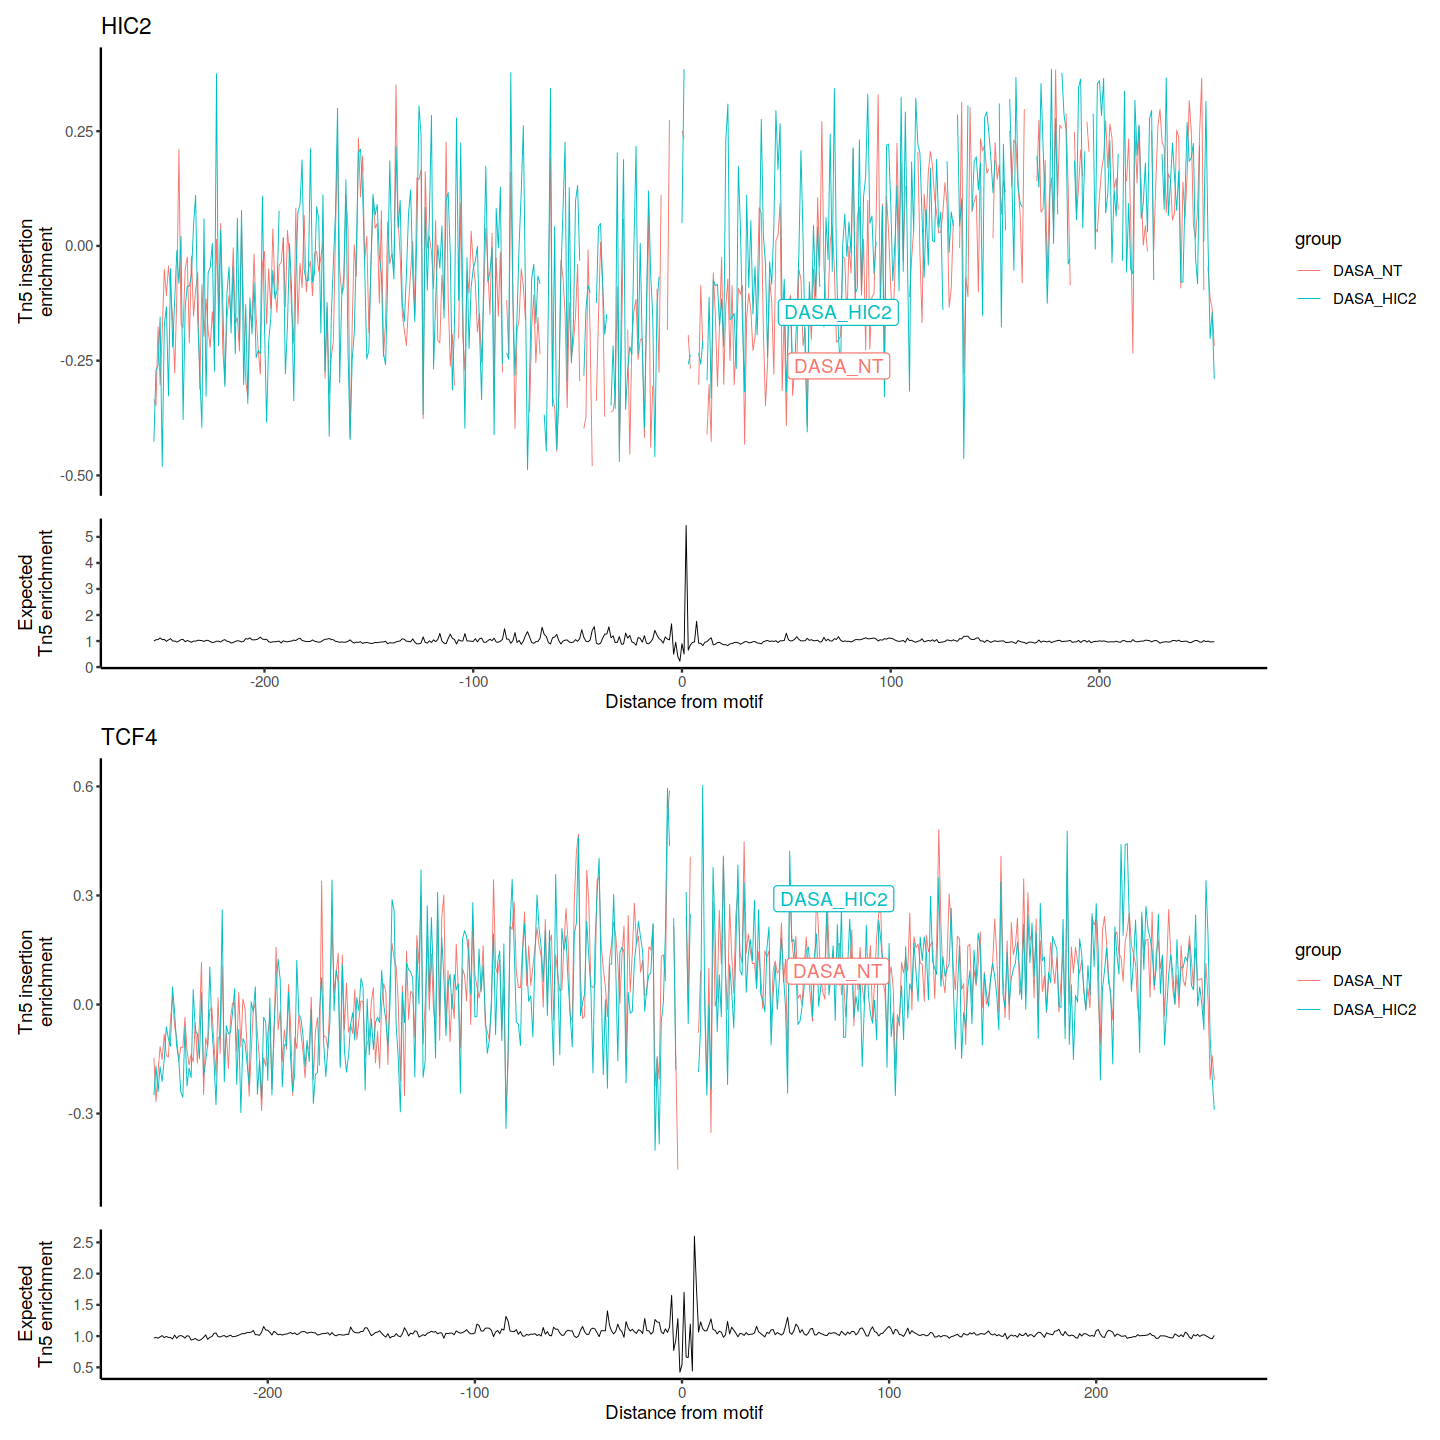

In [67]:
options(repr.plot.width = 12, repr.plot.height = 12)
PlotFootprint(up_sobj, features = c("HIC2", "TCF4")) + patchwork::plot_layout(ncol = 1)

Warning message:
"Removed 1018 rows containing missing values (`geom_label_repel()`)."
Warning message:
"Removed 1026 rows containing missing values (`geom_label_repel()`)."


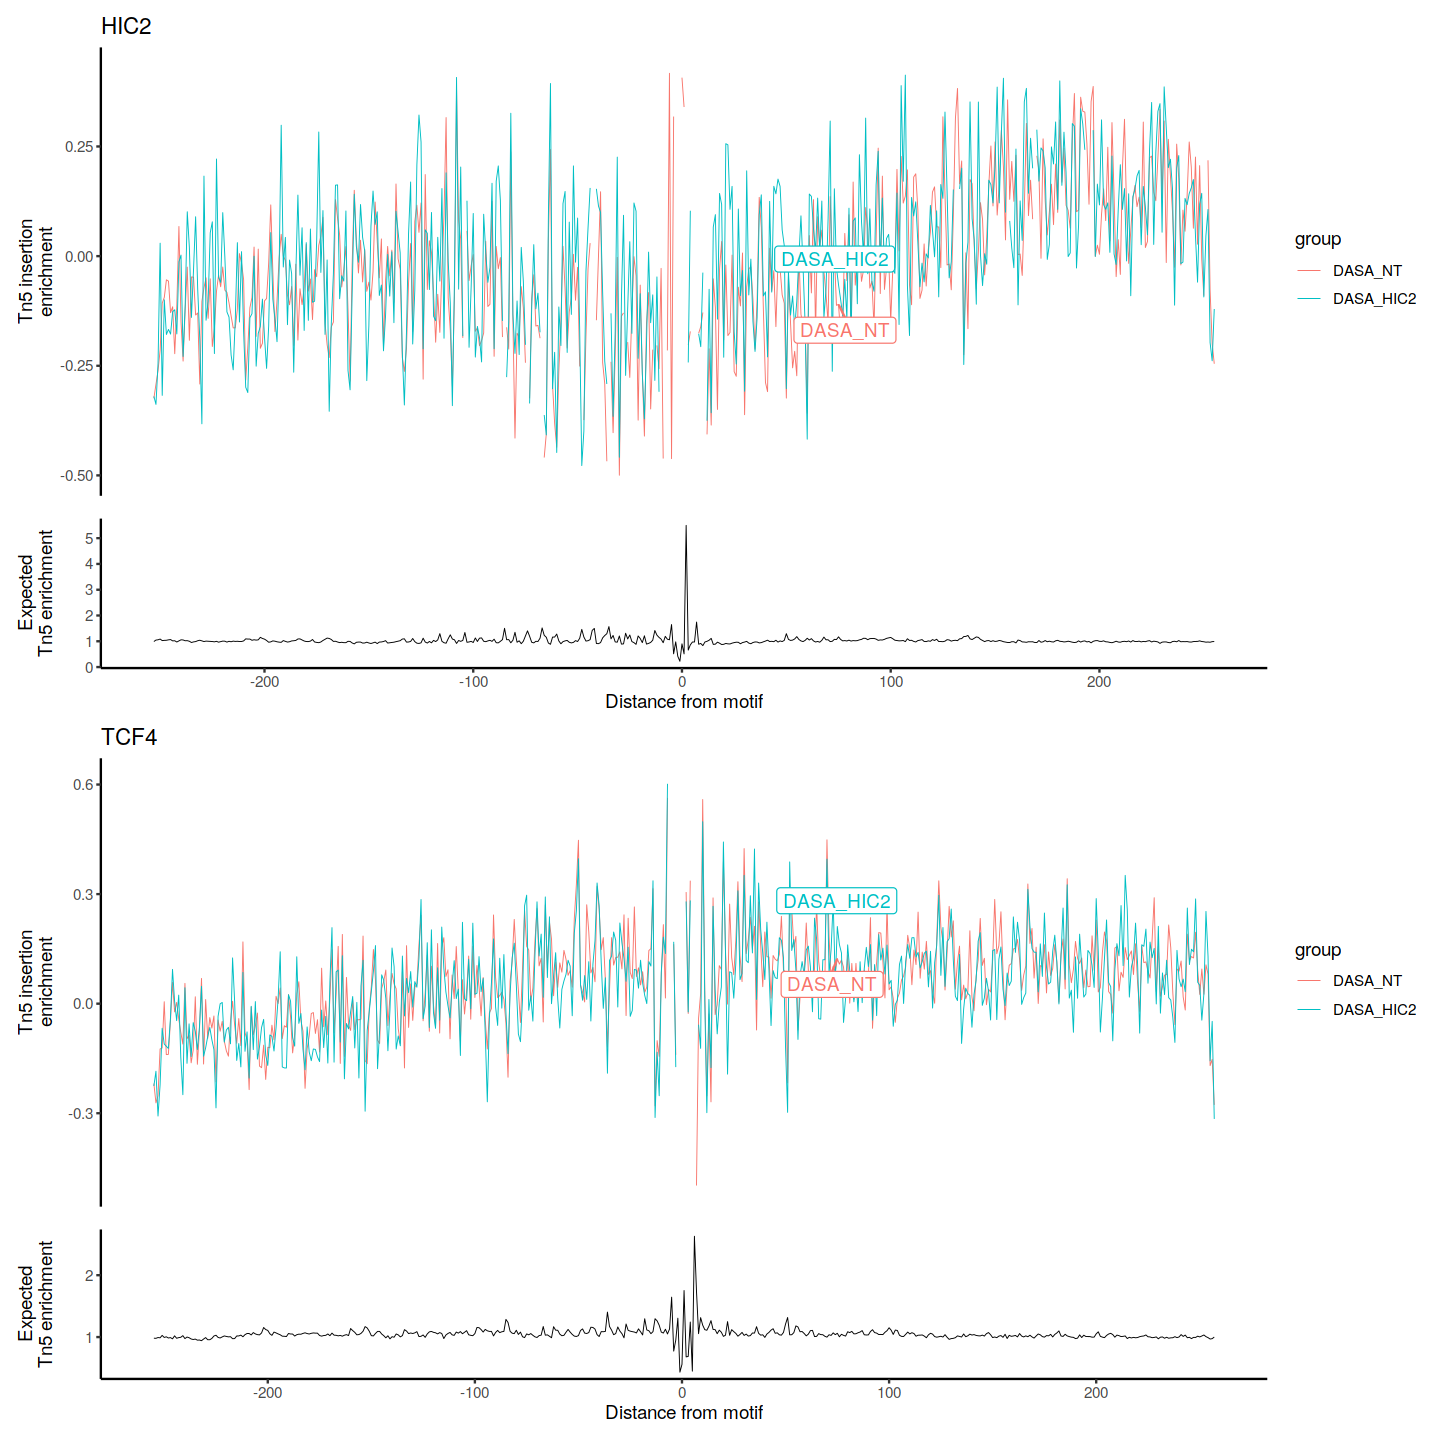

In [68]:
PlotFootprint(down_sobj, features = c("HIC2", "TCF4")) + patchwork::plot_layout(ncol = 1)